In [2]:
# libraries
import sys
sys.path.append("../../models")
from functions import import_country
import pandas as pd 
import numpy as np 
import os 
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib import colors as clrs
import matplotlib.lines as lines
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['ytick.major.width'] = 0.3
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.width'] = 0.2
plt.rcParams['ytick.minor.width'] = 0.2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5

font_dirs = ['../fonts/Bai_Jamjuree/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'Bai Jamjuree'
plt.rcParams['font.sans-serif'] = 'Bai Jamjuree'

colors = ['#6CC2BD', '#5A809E', '#7C79A2', '#F57D7C', '#FFC1A6', '#FEE4C4']
markers = ["o", "s", "^", "*", "P", "d"]
props = dict(facecolor='grey', alpha=0.1, linewidth=0.3)

import warnings
warnings.filterwarnings("ignore")

alpha_s    = [0, 0.1, 1, 10, 100]
countries  = ["Italy", "Canada", "Serbia", "Ukraine", "Egypt", "Peru"]
vaccination_strategies = ["old_first", "homogeneous", "20-49_first"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [3]:
# import data 
with open("../../output/rollout_speed_cases.pkl", "rb") as file: 
    data_cases = pkl.load(file) 
    
# import data 
with open("../../output/rollout_speed.pkl", "rb") as file: 
    data_deaths = pkl.load(file)  

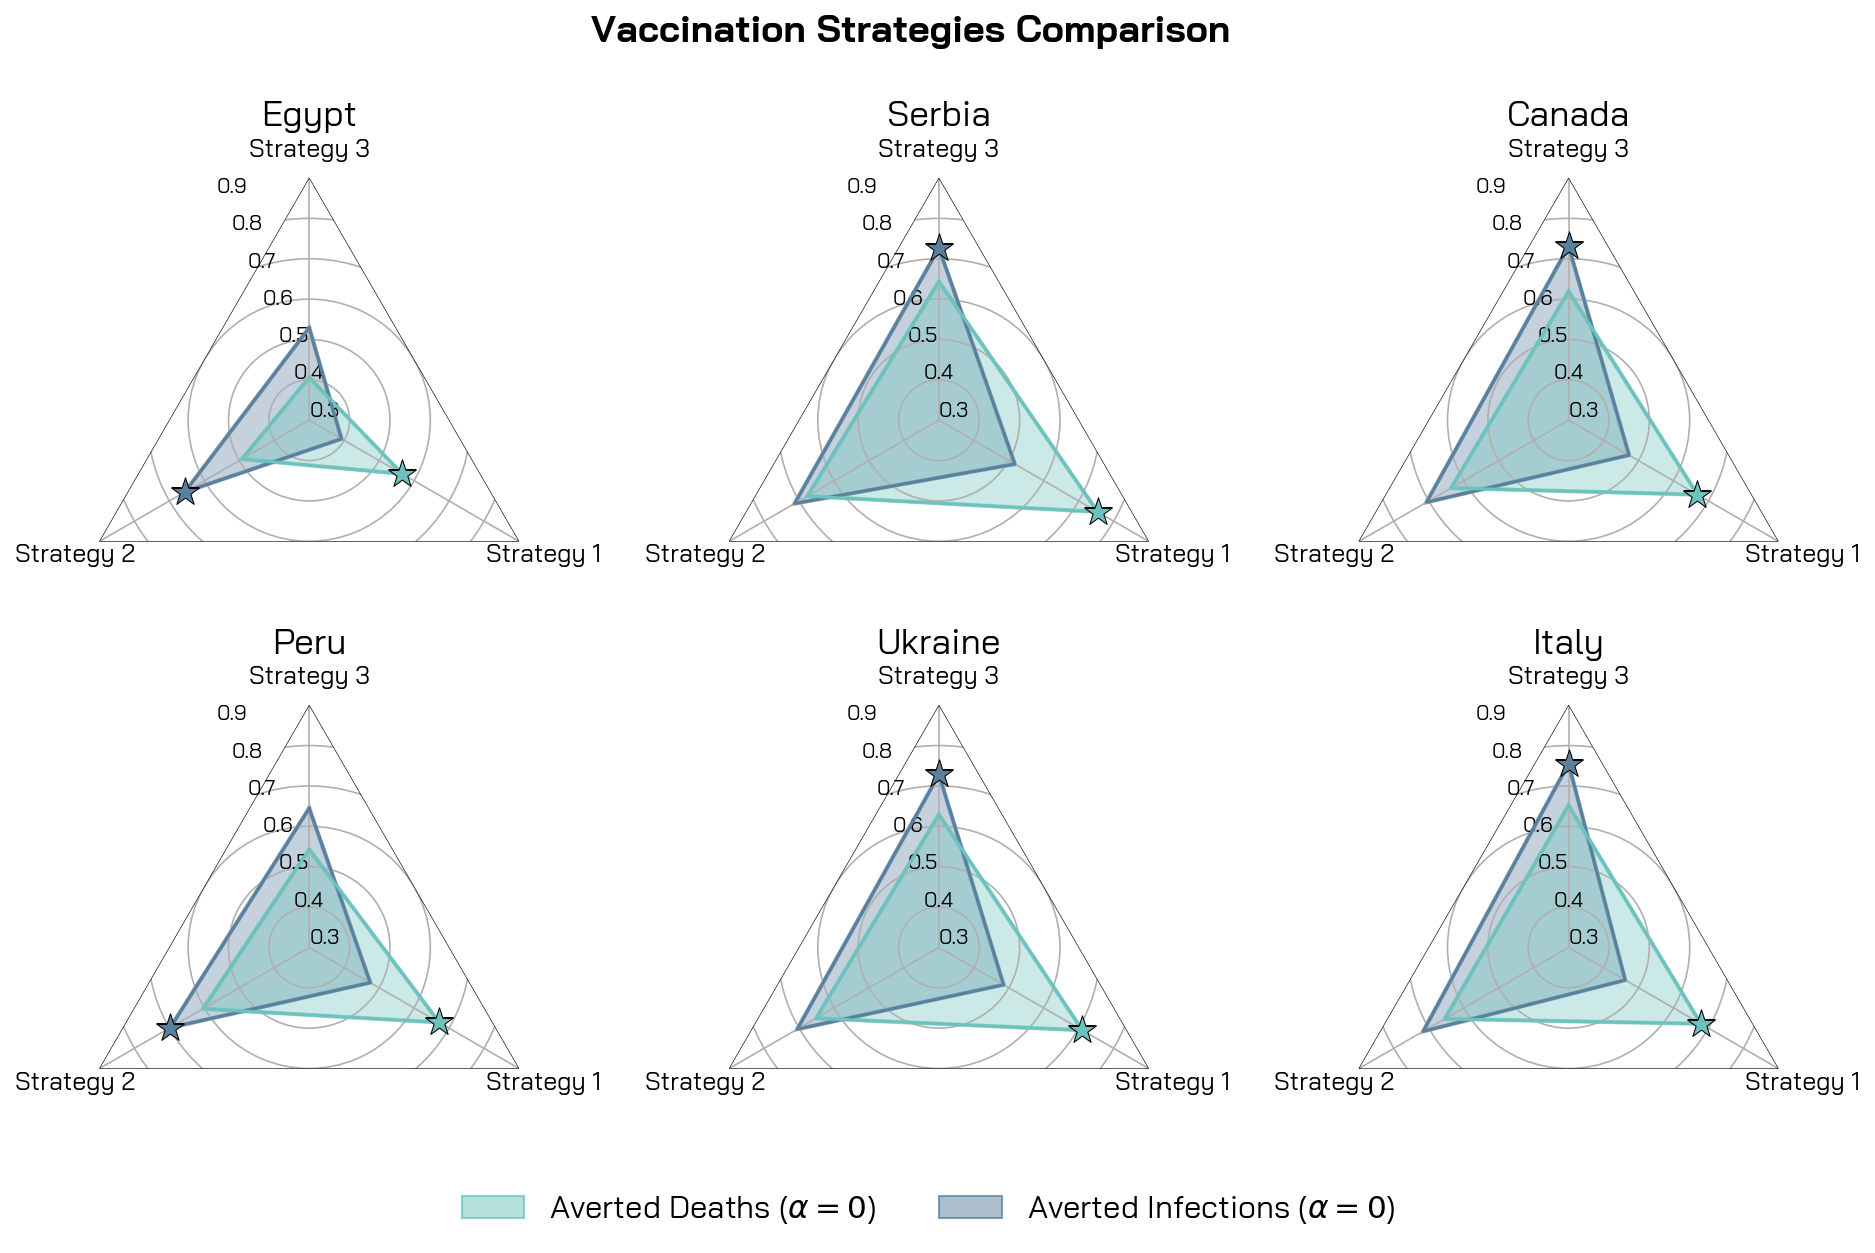

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

data = [['Strategy 3', 'Strategy 2', 'Strategy 1']]
countries = ["Egypt", "Serbia",  "Canada", "Peru", "Ukraine", "Italy"]
for country in countries:
    
    s1, s2 = [], []
    for strategy in ["20-49_first", "homogeneous", "old_first"]:
        
        s1.append(data_deaths[country][0.005][strategy][0])
        s2.append(data_cases[country][0.005][strategy][0])
        
    data.append((country, [s2, s1]))


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=12)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), 3, radius=0.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
        
        def draw(self, renderer):
            # Draw. If frame is polygon, make gridlines polygon-shaped
            gridlines = self.yaxis.get_gridlines()
            for gl in gridlines:
                gl.get_path()._interpolation_steps = 3
            super().draw(renderer)
         
        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


N            = len(data[0])
theta        = radar_factory(N, frame='polygon')   
spoke_labels = data.pop(0)
fig, axes    = plt.subplots(figsize=(15, 15), nrows=2, ncols=3, subplot_kw=dict(projection='radar'), dpi=150)

j, k = 0, 0
for i in range(6):
    
    title, case_data = data[i]
    ax = axes[j, k]

    #ax.set_rgrids([0, 0.5, 1.0, 1.5, 2.0])
    ax.set_ylim(0.3, 0.9)
    ax.set_title(title,  position=(0.5, 1.1), ha='center', fontsize=17)

    c = 0
    hatches=["//", "o"]
    markers=["*", "*"]
    cols = [colors[1], colors[0]]
    for d in case_data:
        line = ax.plot(theta, d, color=cols[c])
        amax = np.argmax(d)
        
        ax.scatter([theta[amax]], [d[amax]], color=cols[c], marker=markers[c], s=200, zorder=10, edgecolor="black", linewidth=0.5)
        ax.fill(theta, d,  alpha=0.35, color=cols[c], linewidth=2)
        ax.fill(theta, d,  alpha=0.35, edgecolor=cols[c],  color="None", linewidth=2)
        c += 1
    ax.set_varlabels(spoke_labels)
    
    k += 1
    if k == 3:
        k = 0
        j += 1
        
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.5, hatch="oo",
                         label='Increase in deaths attributable to behaviour relaxation'),
                   Patch(facecolor=colors[1], edgecolor=colors[1], alpha=0.5, hatch="//",
                         label='Increase in cases attributable to behaviour relaxation')]

p1 = Patch(facecolor="None", edgecolor=colors[0], alpha=0.5)
p2 = Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.5)
p3 = Patch(facecolor="None", edgecolor=colors[1], alpha=0.5)
p4 = Patch(facecolor=colors[1], edgecolor=colors[1], alpha=0.5)
        
axes[1,2].legend([(p1,p2), (p3,p4)], 
                 ['Averted Deaths ($\\alpha=0$)', 
                  'Averted Infections ($\\alpha=0$)'], 
                 ncol=2, bbox_to_anchor=[0.2,0.05,0,0], fontsize=15, frameon=False)
fig.subplots_adjust(hspace=-0.55, wspace=0.3)
fig.suptitle("Vaccination Strategies Comparison", y=0.8, fontsize=18, weight="bold")
plt.savefig("./SM_img/radar_comparison.pdf", bbox_inches="tight")